In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dill
dill.settings['recurse'] = True
from tqdm import tqdm
from triangle import triangulate, plot as tplot
from random import choice, sample, shuffle

In [28]:
F = dill.load(open("../calculations/biharmonic_argyris_double", "rb"))

In [29]:
t = np.linspace(0, 2*np.pi, 111, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T

In [30]:
seg = np.array([[j, j+1] for j in range(points.shape[0]-1)] + [[points.shape[0] - 1, 0]])

In [31]:
cndt = triangulate({"vertices":points, "segments":seg}, opts="Rpq30a0.1neo2")

In [32]:
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
triangles_s = points[triangles]
vertex_maker_is_boundary = cndt["vertex_markers"]

In [33]:
print(f"Total number of points {points.shape[0]}")

Total number of points 942


In [34]:
elem_normal = np.zeros((*triangles.shape, 2))
elem_tangential = np.zeros((*triangles.shape, 2))

def get_mid(a, b):
    
    if (a == 0) and (b == 1):
        return 5
    if (a == 1) and (b == 2):
        return 3
    if (a == 0) and (b == 2):
        return 4
    
    print(f"{a=}, {b=}")
    
for index, element in enumerate(triangles):
    
    elem_tangential[index, 0][0] = points[element[1]][0]-points[element[0]][0]
    elem_tangential[index, 0][1] = points[element[1]][1]-points[element[0]][1]

    elem_normal[index, 0][0] = points[element[1]][1]-points[element[0]][1]
    elem_normal[index, 0][1] = -(points[element[1]][0]-points[element[0]][0])

    elem_tangential[index, 1][0] = points[element[2]][0]-points[element[1]][0]
    elem_tangential[index, 1][1] = points[element[2]][1]-points[element[1]][1]
    
    elem_normal[index, 1][0] = points[element[2]][1]-points[element[1]][1]
    elem_normal[index, 1][1] = -(points[element[2]][0]-points[element[1]][0])    
    
    elem_tangential[index, 2][0] = points[element[0]][0]-points[element[2]][0]
    elem_tangential[index, 2][1] = points[element[0]][1]-points[element[2]][1]
    
    elem_normal[index, 2][0] = points[element[0]][1]-points[element[2]][1]
    elem_normal[index, 2][1] = -(points[element[0]][0]-points[element[2]][0])

    mid1 = get_mid(0, 1)
    mid2 = get_mid(1, 2)
    mid3 = get_mid(0, 2)
    
    elem_normal[index, mid1][0] = -points[element[0]][1]+points[element[1]][1]
    elem_normal[index, mid1][1] = -(-points[element[0]][0]+points[element[1]][0])

    elem_tangential[index, mid1][0] = (-points[element[0]][0]+points[element[1]][0])
    elem_tangential[index, mid1][1] = -points[element[0]][1]+points[element[1]][1]

    elem_normal[index, mid2][0] = -points[element[1]][1]+points[element[2]][1]
    elem_normal[index, mid2][1] = -(-points[element[1]][0]+points[element[2]][0])

    elem_tangential[index, mid2][0] = (-points[element[1]][0]+points[element[2]][0])
    elem_tangential[index, mid2][1] = -points[element[1]][1]+points[element[2]][1]

    elem_normal[index, mid3][0] = -points[element[2]][1]+points[element[0]][1]
    elem_normal[index, mid3][1] = -(-points[element[2]][0]+points[element[0]][0])

    elem_tangential[index, mid3][0] = (-points[element[2]][0]+points[element[0]][0])
    elem_tangential[index, mid3][1] = -points[element[2]][1]+points[element[0]][1]

elem_normal = elem_normal / (elem_normal**2).sum(axis=-1, keepdims=True) ** 0.5
elem_tangential = elem_tangential / (elem_tangential**2).sum(axis=-1, keepdims=True) ** 0.5

# Global normal and tangential

In [35]:
global_elem_normal = np.zeros((points.shape[0], 2))
global_elem_tangential = np.zeros((points.shape[0], 2))
is_set = np.zeros(points.shape[0], dtype=np.bool_)

In [36]:
for index, element in enumerate(triangles):
    
    if is_set[element[0]] == False:
        global_elem_tangential[element[0]][0] = points[element[1]][0]-points[element[0]][0]
        global_elem_tangential[element[0]][1] = points[element[1]][1]-points[element[0]][1]

        global_elem_normal[element[0]][0] = points[element[1]][1]-points[element[0]][1]
        global_elem_normal[element[0]][1] = -(points[element[1]][0]-points[element[0]][0])
        
        is_set[element[0]] = True
        
    if is_set[element[1]] == False:

        global_elem_tangential[element[1]][0] = points[element[2]][0]-points[element[1]][0]
        global_elem_tangential[element[1]][1] = points[element[2]][1]-points[element[1]][1]

        global_elem_normal[element[1]][0] = points[element[2]][1]-points[element[1]][1]
        global_elem_normal[element[1]][1] = -(points[element[2]][0]-points[element[1]][0])    
    
        is_set[element[1]] = True
    
    if is_set[element[2]] == False:

        global_elem_tangential[element[2]][0] = points[element[0]][0]-points[element[2]][0]
        global_elem_tangential[element[2]][1] = points[element[0]][1]-points[element[2]][1]

        global_elem_normal[element[2]][0] = points[element[0]][1]-points[element[2]][1]
        global_elem_normal[element[2]][1] = -(points[element[0]][0]-points[element[2]][0])

        is_set[element[2]] = True
        
    
    if is_set[element[3]] == False:

        global_elem_normal[element[3]][0] = -points[element[1]][1]+points[element[2]][1]
        global_elem_normal[element[3]][1] = -(-points[element[1]][0]+points[element[2]][0])

        global_elem_tangential[element[3]][0] = (-points[element[1]][0]+points[element[2]][0])
        global_elem_tangential[element[3]][1] = -points[element[1]][1]+points[element[2]][1]

        is_set[element[3]] = True

    if is_set[element[4]] == False:

        global_elem_normal[element[4]][0] = -points[element[2]][1]+points[element[0]][1]
        global_elem_normal[element[4]][1] = -(-points[element[2]][0]+points[element[0]][0])

        global_elem_tangential[element[4]][0] = (-points[element[2]][0]+points[element[0]][0])
        global_elem_tangential[element[4]][1] = -points[element[2]][1]+points[element[0]][1]

        is_set[element[4]] = True

    if is_set[element[5]] == False:

        global_elem_normal[element[5]][0] = -points[element[0]][1]+points[element[1]][1]
        global_elem_normal[element[5]][1] = -(-points[element[0]][0]+points[element[1]][0])

        global_elem_tangential[element[5]][0] = (-points[element[0]][0]+points[element[1]][0])
        global_elem_tangential[element[5]][1] = -points[element[0]][1]+points[element[1]][1]

        is_set[element[5]] = True

global_elem_normal = global_elem_normal / (global_elem_normal**2).sum(axis=-1, keepdims=True) ** 0.5
global_elem_tangential = global_elem_tangential / (global_elem_tangential**2).sum(axis=-1, keepdims=True) ** 0.5

# Separate middles

In [37]:
is_middle = np.zeros(points.shape[0], dtype=np.bool_)

for idx, elem in enumerate(triangles):
    
    is_middle[elem[3:]] = True

100%|██████████| 942/942 [00:08<00:00, 108.60it/s]


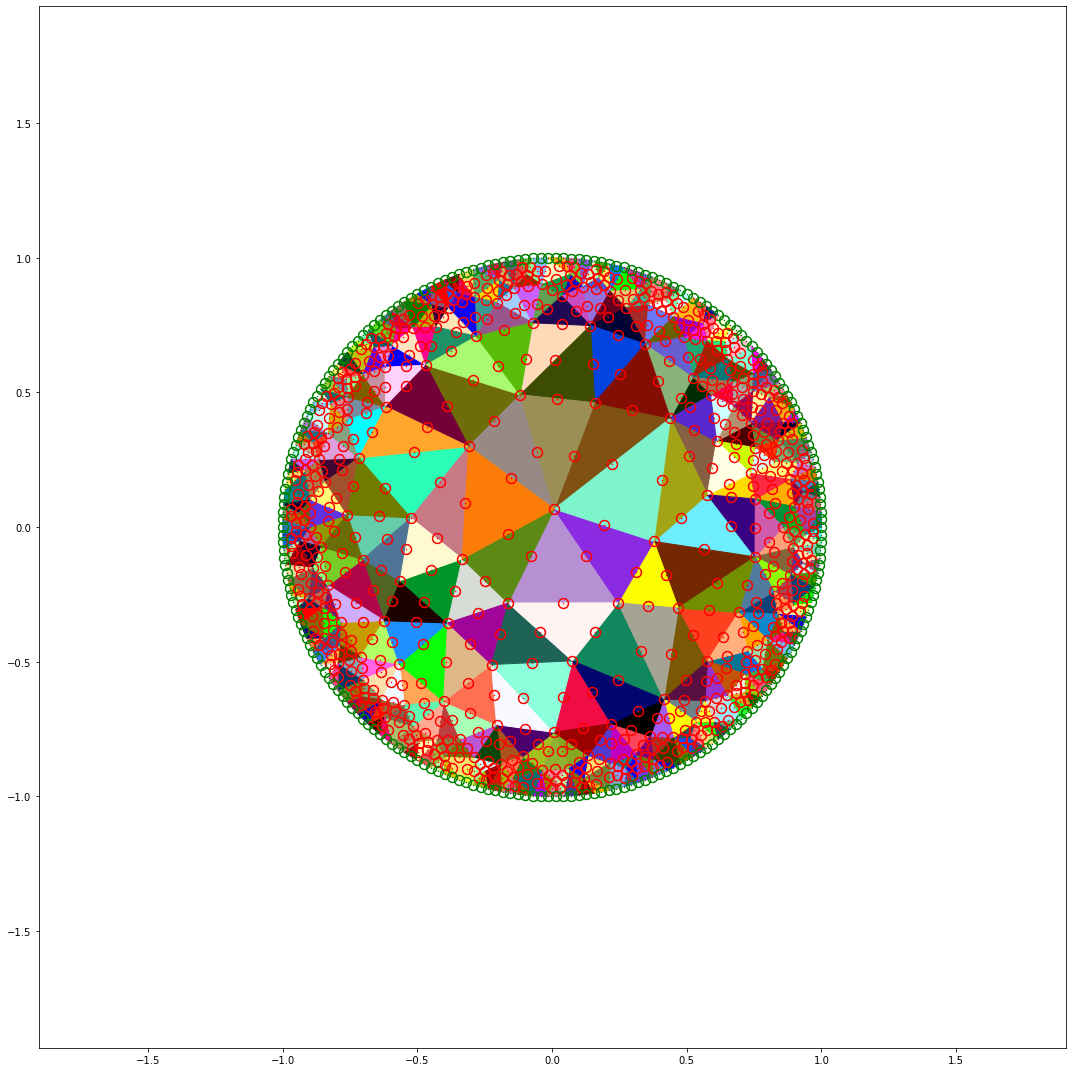

In [38]:
all_colors = list(mcolors.CSS4_COLORS.keys()) + list(mcolors.XKCD_COLORS.keys()) + list(mcolors.BASE_COLORS.keys())
colors = sample(all_colors, triangles_s.shape[0])

%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 15))
ax.axis("equal")

for index, triangle in enumerate(tqdm(triangles_s[:])):
    t1 = plt.Polygon(triangle[:3], color=colors[index])
    fig.gca().add_patch(t1)
    
for idx, point in enumerate(tqdm(points)):
    
    if vertex_maker_is_boundary[idx] == 0:
        color = "red"
    else:
        color = "green"
    ax.scatter(point[0], point[1], color=color, lw=10, s=2)
#     ax.text(x=point[0]+0.005, y=point[1]+0.05, s=f"{idx}", fontsize=20, color="black")

    
#     if is_middle[idx] == True:
#         ax.quiver(point[0], point[1], global_elem_normal[idx][0], global_elem_normal[idx][1], color="red", scale=21)
#         ax.quiver(point[0], point[1], global_elem_tangential[idx][0], global_elem_tangential[idx][1], color="green", scale=21)
    
    

if not True:

    for idx, elem in enumerate(triangles):
#         continue
        for j in range(6):
            if is_middle[elem[j]] == False:
                continue
            ax.quiver(points[elem[j]][0], points[elem[j]][1], elem_tangential[idx,j,0], elem_tangential[idx,j,1], color="green", scale=21)
            ax.quiver(points[elem[j]][0], points[elem[j]][1], elem_normal[idx,j,0], elem_normal[idx,j,1], color="red", scale=21)

        
    
ax.set_xlim([points[:, 0].min()-1, points[:, 0].max()+1])
ax.set_ylim([points[:, 1].min()-1, points[:, 1].max()+1])

fig.tight_layout()
plt.tight_layout()

plt.show()

In [39]:
total_points = points.shape[0]
num_midpoints = is_middle.sum()
num_nodes = total_points - num_midpoints
NUM = 6 * num_nodes + num_midpoints

In [49]:
matrix = np.zeros((NUM, NUM), dtype=np.float32)
b = np.zeros((NUM),  dtype=np.float32)

for idx, element in enumerate(tqdm(triangles)):

#----------------P's----------------------------------------------------------------
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]
    
    delta = x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2
    
    P_1_x = (-y1 + y3) / delta
    P_1_y = (+x1 - x3) / delta
    
    P_2_x = (+y1 - y2) / delta
    P_2_y = (-x1 + x2) / delta
#------------------------------------------------------------------------------------

#----------------------Lengths-------------------------------------------------------
    l1 = ((x2 - x3)**2 + (y2 - y3)**2)**0.5
    l2 = ((x1 - x3)**2 + (y1 - y3)**2)**0.5
    l3 = ((x1 - x2)**2 + (y1 - y2)**2)**0.5
#------------------------------------------------------------------------------------

#----------------------J_inv_T-------------------------------------------------------
    J11 = (-x1 + x2)
    J12 = (-y1 + y2)
    
    J21 = (-x1 + x3)
    J22 = (-y1 + y3)
    
    J_inv_T = np.array([
                        [J11, J12], 
                        [J21, J22]
                       ])
#-----------------------------------------------------------------------------------    

#-----------------------nomal and tangential----------------------------------------
    n1 = elem_normal[idx, 3]
    t1 = elem_tangential[idx, 3]


    n2 = elem_normal[idx, 4]
    t2 = elem_tangential[idx, 4]

    
    n3 = elem_normal[idx, 5]
    t3 = elem_tangential[idx, 5]
    
    
    DN_n1 = global_elem_normal[triangles[idx]][3]
    DN_t1 = global_elem_tangential[triangles[idx]][3]


    DN_n2 = global_elem_normal[triangles[idx]][4]
    DN_t2 = global_elem_tangential[triangles[idx]][4]

    
    DN_n3 = global_elem_normal[triangles[idx]][5]
    DN_t3 = global_elem_tangential[triangles[idx]][5]
#------------------------------------------------------------------------------------

#------------------------G's---------------------------------------------------------
    G1 = np.array([
        [*n1],
        [*t1]
    ])
    
    G2 = np.array([
        [*n2],
        [*t2]
    ])
    
    G3 = np.array([
        [*n3],
        [*t3]
    ])
    
    G1_hat = np.array([
        [+np.sqrt(1/2), +np.sqrt(1/2)],
        [-np.sqrt(1/2), +np.sqrt(1/2)],
    ])
    
    G2_hat = np.array([
        [-1, +0],
        [+0, -1],
    ])
    
    G3_hat = np.array([
        [+0, -1],
        [+1, +0]
    ])

    
    B1 = G1_hat @ J_inv_T @ G1.T
    B2 = G2_hat @ J_inv_T @ G2.T
    B3 = G3_hat @ J_inv_T @ G3.T
                                                        
    DN_G1 = np.array([
        [*DN_n1],
        [*DN_t1]
    ])
    
    DN_G2 = np.array([
        [*DN_n2],
        [*DN_t2]
    ])
    
    DN_G3 = np.array([
        [*DN_n3],
        [*DN_t3]
    ])

    
    DN_B1 = G1_hat @ J_inv_T @ DN_G1.T
    DN_B2 = G2_hat @ J_inv_T @ DN_G2.T
    DN_B3 = G3_hat @ J_inv_T @ DN_G3.T                                                            
#------------------------------------------------------------------------------------
    

#----------------------THETA---------------------------------------------------------
    THETA = np.array([
        [P_1_x**2, 2*P_1_x*P_2_x, P_2_x**2],
        [P_1_y*P_1_x, P_1_y*P_2_x + P_1_x*P_2_y, P_2_x*P_2_y],
        [P_1_y**2, 2*P_1_y*P_2_y, P_2_y**2],
    ])
    
    THETA = np.linalg.inv(THETA)
#------------------------------------------------------------------------------------


#--------------------args------------------------------------------------------------
    args = [
        P_1_x, P_2_x, 
        P_1_y, P_2_y,
        *n1, *n2, *n3, 
        *t1, *t2, *t3,
        l1, l2, l3,
        *J_inv_T.flatten(),
        *THETA.flatten(),
        *B1.flatten(),
        *B2.flatten(),
        *B3.flatten(),
        *DN_B1.flatten(),
        *DN_B2.flatten(),
        *DN_B3.flatten()
       ]
#------------------------------------------------------------------------------------
    
    # p_1
    if vertex_maker_is_boundary[element[0]] == True:
        
        matrix[6 * element[0], 6 * element[0]] = 1
        
        for i in range(1, 6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[0]+i, 6*element[j]+k] += 2 * F[f"{3*i+0}_{3*k+j}_b"](*args) * delta
                    
                #midpoints
                for k in range(3,6):
                    matrix[6*element[0]+i, 6*num_nodes+(element[k]-num_nodes)] += 2 * F[f"{3*i+0}_{18+(k-3)}_b"](*args) * delta
        
        b[6 * element[0]+0] = 0
        b[6 * element[0]+1] += 2 * F["3"](*args) * delta
        b[6 * element[0]+2] += 2 * F["6"](*args) * delta
        b[6 * element[0]+3] += 2 * F["9"](*args) * delta
        b[6 * element[0]+4] += 2 * F["12"](*args)* delta
        b[6 * element[0]+5] += 2 * F["15"](*args)* delta
    
    else:
        
        for i in range(6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[0]+i, 6*element[j]+k] += 2 * F[f"{3*i+0}_{3*k+j}_b"](*args) * delta
                    
                #midpoint
                for k in range(3,6):
                    matrix[6*element[0]+i, 6*num_nodes+(element[k]-num_nodes)] += 2 * F[f"{3*i+0}_{18+(k-3)}_b"](*args) * delta
                       
        b[6 * element[0]+0] += 2 * F["0" ](*args) * delta
        b[6 * element[0]+1] += 2 * F["3" ](*args) * delta
        b[6 * element[0]+2] += 2 * F["6" ](*args) * delta
        b[6 * element[0]+3] += 2 * F["9" ](*args) * delta
        b[6 * element[0]+4] += 2 * F["12"](*args) * delta
        b[6 * element[0]+5] += 2 * F["15"](*args) * delta
        
        
    # p_2
    if vertex_maker_is_boundary[element[1]] == True:
        
        matrix[6 * element[1], 6 * element[1]] = 1
        
        for i in range(1, 6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[1]+i, 6*element[j]+k] += 2 * F[f"{3*i+1}_{3*k+j}_b"](*args) * delta
                    
                #midpoints
                for k in range(3,6):
                    matrix[6*element[1]+i, 6*num_nodes+(element[k]-num_nodes)] += 2 * F[f"{3*i+1}_{18+(k-3)}_b"](*args) * delta
                       
        
        b[6 * element[1]+0] = 0
        b[6 * element[1]+1] += 2 * F["4" ](*args) * delta
        b[6 * element[1]+2] += 2 * F["7" ](*args) * delta
        b[6 * element[1]+3] += 2 * F["10"](*args) * delta
        b[6 * element[1]+4] += 2 * F["13"](*args) * delta
        b[6 * element[1]+5] += 2 * F["16"](*args) * delta
    
    else:
        
        for i in range(6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[1]+i, 6*element[j]+k] += 2 * F[f"{3*i+1}_{3*k+j}_b"](*args) * delta
                    
                #midpoint
                for k in range(3,6):
                    matrix[6*element[1]+i, 6*num_nodes+(element[k]-num_nodes)] += 2 * F[f"{3*i+1}_{18+(k-3)}_b"](*args) * delta
                       
        b[6 * element[1]+0] += 2 * F["1" ](*args) * delta
        b[6 * element[1]+1] += 2 * F["4" ](*args) * delta
        b[6 * element[1]+2] += 2 * F["7" ](*args) * delta
        b[6 * element[1]+3] += 2 * F["10"](*args) * delta
        b[6 * element[1]+4] += 2 * F["13"](*args) * delta
        b[6 * element[1]+5] += 2 * F["16"](*args) * delta
            
        
    # p_3
    if vertex_maker_is_boundary[element[2]] == True:
        
        matrix[6 * element[2], 6 * element[2]] = 1
        
        for i in range(1, 6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[2]+i, 6*element[j]+k] += 2 * F[f"{3*i+2}_{3*k+j}_b"](*args) * delta
                    
                #midpoints
                for k in range(3,6):
                    matrix[6*element[2]+i, 6*num_nodes+(element[k]-num_nodes)] += 2 * F[f"{3*i+2}_{18+(k-3)}_b"](*args) * delta
                       
        
        b[6 * element[2]+0] = 0
        b[6 * element[2]+1] += 2 * F["5" ](*args) * delta
        b[6 * element[2]+2] += 2 * F["8" ](*args) * delta
        b[6 * element[2]+3] += 2 * F["11"](*args) * delta
        b[6 * element[2]+4] += 2 * F["14"](*args) * delta
        b[6 * element[2]+5] += 2 * F["17"](*args) * delta
    
    else:
        
        for i in range(6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[2]+i, 6*element[j]+k] += 2 * F[f"{3*i+2}_{3*k+j}_b"](*args) * delta
                    
                #midpoint
                for k in range(3,6):
                    matrix[6*element[2]+i, 6*num_nodes+(element[k]-num_nodes)] += 2 * F[f"{3*i+2}_{18+(k-3)}_b"](*args) * delta
                       
        b[6 * element[2]+0] += 2 * F["2"](*args) * delta
        b[6 * element[2]+1] += 2 * F["5"](*args) * delta
        b[6 * element[2]+2] += 2 * F["8"](*args) * delta
        b[6 * element[2]+3] += 2 * F["11"](*args) * delta
        b[6 * element[2]+4] += 2 * F["14"](*args)* delta
        b[6 * element[2]+5] += 2 * F["17"](*args)* delta
    
    
    
    # m_1
    if vertex_maker_is_boundary[element[3]] == True:
        matrix[6*num_nodes+(element[3]-num_nodes), 6*num_nodes+(element[3]-num_nodes)] = 1
        b[6*num_nodes+(element[3]-num_nodes)] = 0
        
    else:

        for j in range(3):
            for k in range(6):
                matrix[6*num_nodes+(element[3]-num_nodes), 6*element[j]+k] += 2 * F[f"{18}_{3*k+j}_b"](*args) * delta

            #midpoints
            for k in range(3,6):
                matrix[6*num_nodes+(element[3]-num_nodes), 6*num_nodes+(element[k]-num_nodes)] += 2 * F[f"{18}_{18+(k-3)}_b"](*args) * delta

        b[6*num_nodes+(element[3]-num_nodes)] += 2 * F["18"](*args) * delta
        
    # m_2
    if vertex_maker_is_boundary[element[4]] == True:
        matrix[6*num_nodes+(element[4]-num_nodes), 6*num_nodes+(element[4]-num_nodes)] = 1
        b[6*num_nodes+(element[4]-num_nodes)] = 0
        
    else:

        for j in range(3):
            for k in range(6):
                matrix[6*num_nodes+(element[4]-num_nodes), 6*element[j]+k] += 2 * F[f"{19}_{3*k+j}_b"](*args) * delta

            #midpoints
            for k in range(3,6):
                matrix[6*num_nodes+(element[4]-num_nodes), 6*num_nodes+(element[k]-num_nodes)] += 2 * F[f"{19}_{18+(k-3)}_b"](*args) * delta

        b[6*num_nodes+(element[4]-num_nodes)] += 2 * F["19"](*args) * delta
        
    # m_3
    if vertex_maker_is_boundary[element[5]] == True:
        
        matrix[6*num_nodes+(element[5]-num_nodes), 6*num_nodes+(element[5]-num_nodes)] = 1
        b[6*num_nodes+(element[5]-num_nodes)] = 0
    else:

        for j in range(3):
            for k in range(6):
                matrix[6*num_nodes+(element[5]-num_nodes), 6*element[j]+k] += 2 * F[f"{20}_{3*k+j}_b"](*args) * delta

            #midpoints
            for k in range(3,6):
                matrix[6*num_nodes+(element[5]-num_nodes), 6*num_nodes+(element[k]-num_nodes)] += 2 * F[f"{20}_{18+(k-3)}_b"](*args) * delta

        b[6*num_nodes+(element[5]-num_nodes)] += 2 * F["20"](*args) * delta

100%|██████████| 415/415 [00:09<00:00, 42.37it/s]


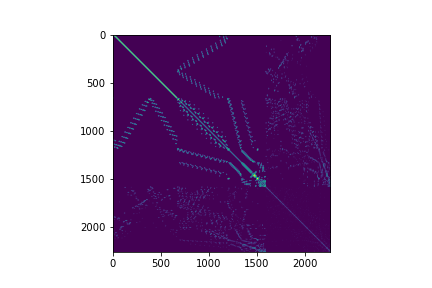

In [50]:
fig, ax = plt.subplots()
ax.imshow(matrix != 0)
plt.show()

In [51]:
c = np.linalg.solve(matrix, b)

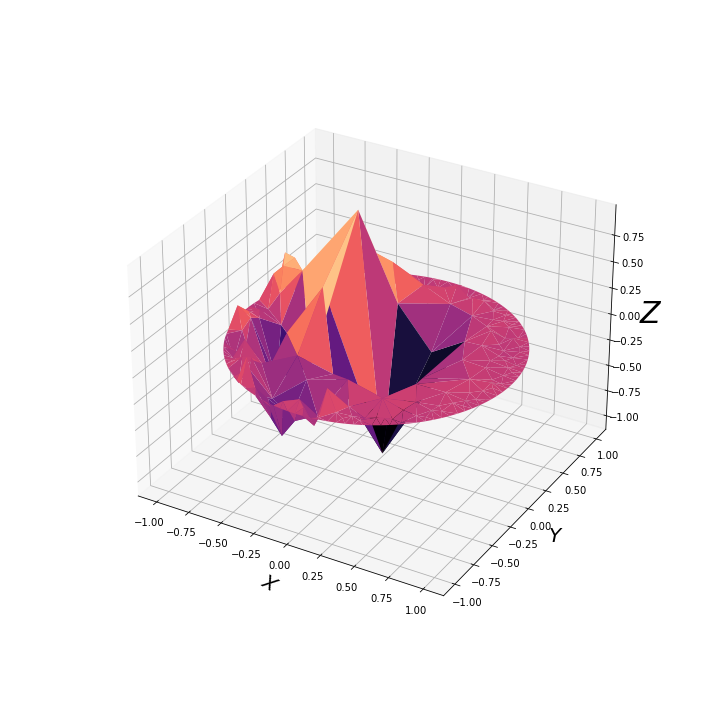

In [52]:
%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.set_xlabel('$X$', fontsize=20, rotation=150)
ax.set_ylabel('$Y$', fontsize=20, rotation=0)
ax.set_zlabel('$Z$', fontsize=30, rotation=0)

ax.plot_trisurf(points[:num_nodes, 0], 
                points[:num_nodes, 1], 
                c[:6*num_nodes:6], cmap="magma")
plt.show()

In [71]:
# %matplotlib inline
# fig, ax = plt.subplots(figsize=(10, 10))
# plt.imshow(matrix != 0)
# plt.show()